In [13]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [14]:
data = pd.read_csv("../data/modeling.csv")
train, test = train_test_split(data, train_size = .8)

# Feature Selection/EDA

Checking missing values

In [15]:
print(data.isnull().sum())
test.describe()

Date                        0
Province_State              0
Confirmed                   0
Deaths                      0
Active                  34894
Testing_Rate             4031
Hospitalization_Rate    44823
dtype: int64


Confirmed        Deaths        Active  Testing_Rate  \
count  9.991000e+03   9991.000000  3.041000e+03  9.196000e+03   
mean   7.510735e+05  10693.094285  5.927875e+04  1.151072e+05   
std    1.264143e+06  15909.422365  1.170860e+05  1.292136e+05   
min    0.000000e+00      0.000000  0.000000e+00  5.973514e-08   
25%    6.479000e+04   1123.500000  3.117000e+03  6.937772e+03   
50%    3.031960e+05   4586.000000  1.436700e+04  7.538393e+04   
75%    8.732090e+05  13288.000000  6.150700e+04  1.782606e+05   
max    1.122421e+07  95502.000000  1.373423e+06  7.886591e+05   

       Hospitalization_Rate  
count           1028.000000  
mean              12.165152  
std                5.324999  
min                2.205882  
25%                8.366687  
50%               11.387008  
75%               15.198618  
max               38.501190

Checking if we can safely drop rows with testing rate = nan

Text(0.5, 1.0, 'Log Death Distribution')

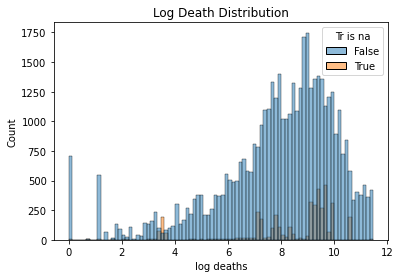

In [16]:
data["Tr is na"] = data["Testing_Rate"].isna()
data["log deaths"] = np.log(data["Deaths"] + 1)
sns.histplot(data, x ="log deaths", hue = "Tr is na")
plt.title("Log Death Distribution")

checking if we should take logs of several distributions

Text(0.5, 1.0, 'Distribution of log of all deaths')

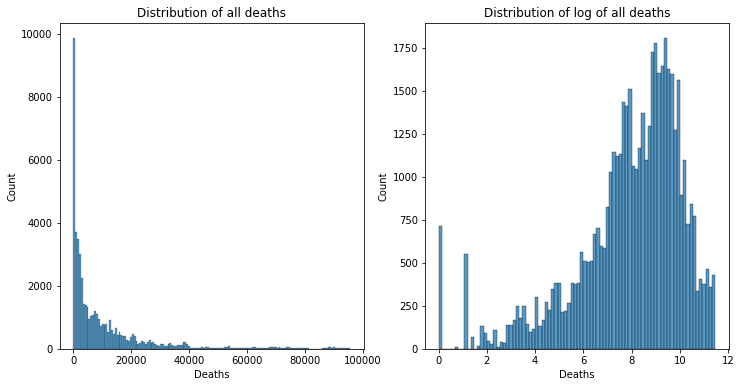

In [17]:
plt.figure(figsize=(12,6))
plt.subplot(121)
sns.histplot(data["Deaths"])
plt.title("Distribution of all deaths")
plt.subplot(122)
sns.histplot(np.log(data["Deaths"] + 1))
plt.title("Distribution of log of all deaths")

Text(0.5, 1.0, 'Distribution of log of all cases')

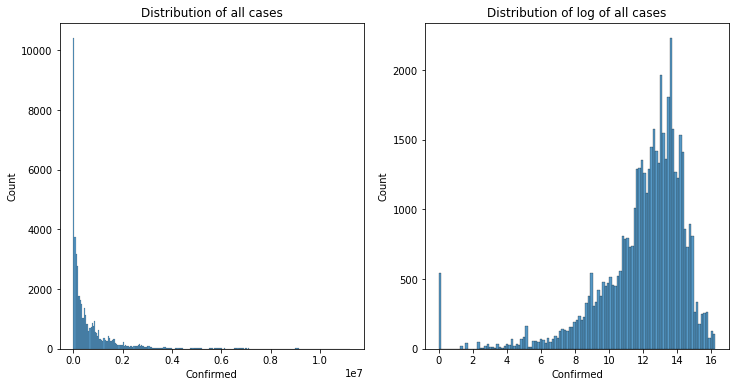

In [18]:
plt.figure(figsize=(12,6))
plt.subplot(121)
sns.histplot(data["Confirmed"])
plt.title("Distribution of all cases")
plt.subplot(122)
sns.histplot(np.log(data["Confirmed"] + 1))
plt.title("Distribution of log of all cases")

Text(0.5, 1.0, 'Distribution of log testing rates')

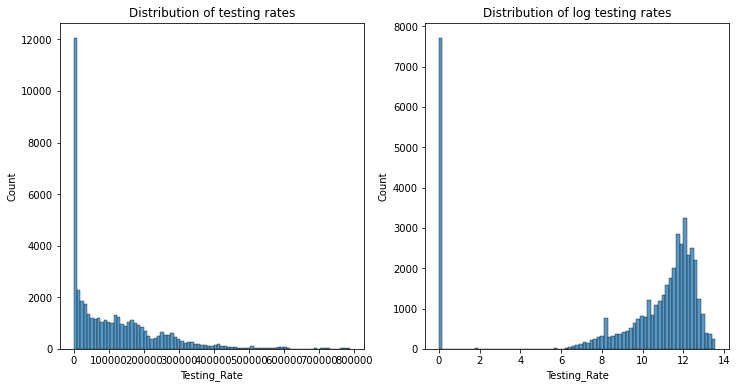

In [19]:
plt.figure(figsize=(12,6))
plt.subplot(121)
sns.histplot(data["Testing_Rate"].dropna())
plt.title("Distribution of testing rates")
plt.subplot(122)
sns.histplot(np.log(data["Testing_Rate"].dropna() + 1))
plt.title("Distribution of log testing rates")

Text(0.5, 1.0, 'Distribution of log dates')

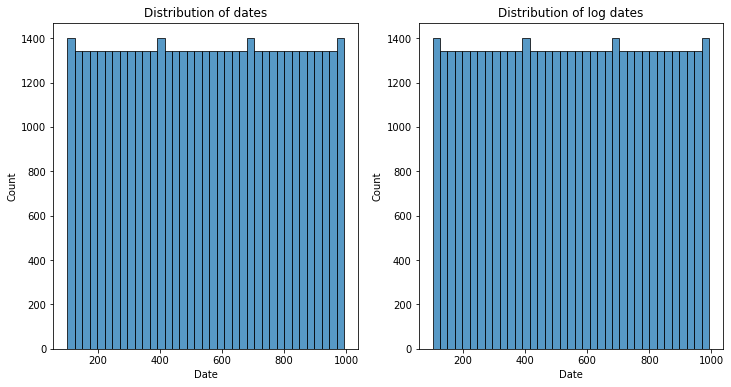

In [20]:
temp = pd.to_datetime(data["Date"]) - pd.to_datetime('2020-1-1',format='%Y-%m-%d')
temp = temp.dt.days
plt.figure(figsize=(12,6))
plt.subplot(121)
sns.histplot(temp)
plt.title("Distribution of dates")
plt.subplot(122)
sns.histplot(temp)
plt.title("Distribution of log dates")

# Data Processing

In [21]:
def process_data(data, predictor, test = False, time_limit = 9999):
    features = pd.get_dummies(data["Province_State"])
    features["Testing_Rate"] = np.log(data["Testing_Rate"] + 1)
    features["Date"] = pd.to_datetime(data["Date"]) - pd.to_datetime('2020-1-1',format='%Y-%m-%d')
    features["Date"] = features["Date"].dt.days
    features = features[features["Date"] < time_limit]
    features["Confirmed"] = np.log(data["Confirmed"] + 1)
    features["Deaths"] = np.log(data["Deaths"] + 1)
    features = features.dropna()
    #print(features.columns)
    X = features.drop(columns = [predictor]).to_numpy()
    if test:
        return X
    Y = features[predictor].to_numpy()
    return X, Y

# Model 1 - Predicting Death Rate

In [22]:
X_train_deaths, Y_train_deaths = process_data(train, "Deaths")
X_test_deaths, Y_test_deaths = process_data(test, "Deaths")
print(X_train_deaths.shape, Y_train_deaths.shape)
print(X_test_deaths.shape, Y_test_deaths.shape)

(36725, 59) (36725,)
(9196, 59) (9196,)


In [23]:
deaths_model = LinearRegression()
deaths_model.fit(X_train_deaths, Y_train_deaths)
training_accuracy = deaths_model.score(X_train_deaths, Y_train_deaths)
print("Training Accuracy:   ", training_accuracy)
validation_accuracy = deaths_model.score(X_test_deaths, Y_test_deaths)
print("Validation Accuracy: ", validation_accuracy)

Training Accuracy:    0.9834122788120578
Validation Accuracy:  0.9823035023819403


# Modeling Deaths as Data Gets Released

In [24]:
temp = pd.to_datetime(data["Date"]) - pd.to_datetime('2020-1-1',format='%Y-%m-%d')
temp = temp.dt.days
train_scores = []
val_scores = []
for limit in range(min(temp + 1), max(temp) + 1):
    X_train_deaths, Y_train_deaths = process_data(train, "Deaths", time_limit=limit)
    X_test_deaths, Y_test_deaths = process_data(test, "Deaths", time_limit=limit)
    deaths_model = LinearRegression()
    deaths_model.fit(X_train_deaths, Y_train_deaths)
    training_accuracy = deaths_model.score(X_train_deaths, Y_train_deaths)
    validation_accuracy = deaths_model.score(X_test_deaths, Y_test_deaths)
    train_scores.append(deaths_model.score(X_train_deaths, Y_train_deaths))
    val_scores.append(deaths_model.score(X_test_deaths, Y_test_deaths))

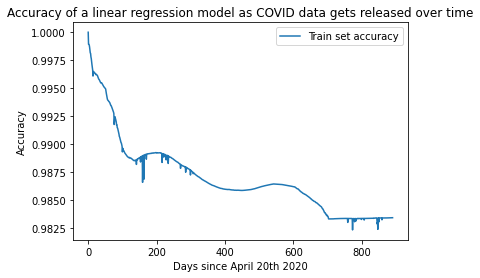

In [25]:
plt.plot(train_scores, label = "Train set accuracy")
plt.xlabel("Days since April 20th 2020")
plt.ylabel("Accuracy")
plt.title("Accuracy of a linear regression model as COVID data gets released over time")
plt.legend()

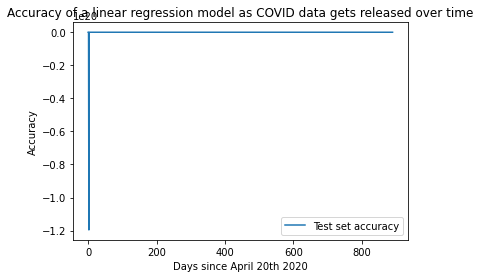

In [26]:
plt.plot(val_scores, label = "Test set accuracy")
plt.xlabel("Days since April 20th 2020")
plt.ylabel("Accuracy")
plt.title("Accuracy of a linear regression model as COVID data gets released over time")
plt.legend()

# Model 2 - Predicting Testing Rates

In [27]:
X_train_tr, Y_train_tr = process_data(train, "Testing_Rate")
X_test_tr, Y_test_tr = process_data(test, "Testing_Rate")
print(X_train_tr.shape, Y_train_tr.shape)
print(X_test_tr.shape, Y_test_tr.shape)

(36725, 59) (36725,)
(9196, 59) (9196,)


In [28]:
tr_model = LinearRegression(fit_intercept=False)
tr_model.fit(X_train_tr, Y_train_tr)
training_accuracy = tr_model.score(X_train_tr, Y_train_tr)
print("Training Accuracy:   ", training_accuracy)
validation_accuracy = tr_model.score(X_test_tr, Y_test_tr)
print("Validation Accuracy: ", validation_accuracy)

Training Accuracy:    0.9653864028448603
Validation Accuracy:  0.9708781158590635


# Results Analysis - Deaths Model

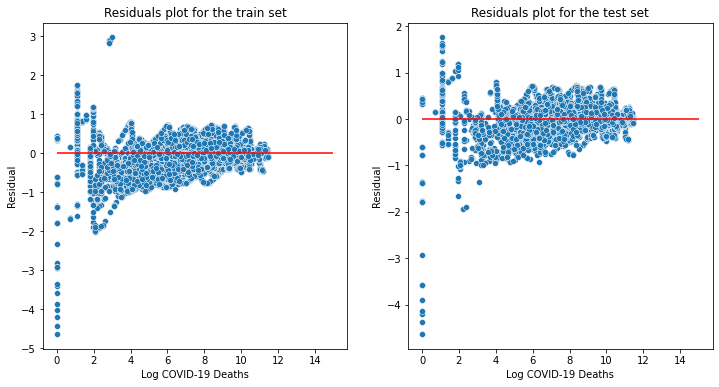

In [30]:
train_residuals = Y_train_deaths - deaths_model.predict(X_train_deaths)
test_residuals = Y_test_deaths - deaths_model.predict(X_test_deaths)
plt.figure(figsize=(12,6))
plt.subplot(121)
sns.scatterplot(x = Y_train_deaths, y = train_residuals)
plt.title("Residuals plot for the train set")
plt.xlabel("Log COVID-19 Deaths")
plt.ylabel("Residual")
plt.hlines(0, 0, 15, "r")
plt.subplot(122)
sns.scatterplot(x = Y_test_deaths, y = test_residuals)
plt.title("Residuals plot for the test set")
plt.xlabel("Log COVID-19 Deaths")
plt.ylabel("Residual")
plt.hlines(0, 0, 15, "r")

In [31]:
print(deaths_model.coef_, deaths_model.intercept_)
print(tr_model.coef_, tr_model.intercept_)

[-1.48522277e-15 -1.39330696e+00  9.15086854e-01  4.21795172e-01
 -3.46929193e-02  4.75085985e-01  6.96768012e-02  5.99573653e-01
 -3.35205284e-02  1.70036829e-02  4.88157032e-01  4.64949470e-01
 -9.13387906e-01 -8.33275656e-01 -4.16596734e-01  5.56084595e-01
  5.28538372e-01 -4.89605678e-02 -1.69610744e-01 -2.61445207e-02
  4.85991251e-01 -4.57543811e-01  4.91912633e-01  6.97821488e-01
  8.14278038e-01  2.41741842e-02  3.53726981e-01  1.65763309e-01
 -4.02838802e-01 -5.76794143e-01  7.06141966e-02 -2.19691316e-01
  8.82883453e-01  1.21219259e-01  1.02191898e+00  1.85757177e-01
 -5.07308778e-01 -1.31858228e+00  6.16472168e-01 -7.07335064e-02
 -2.32448576e-01  7.65974455e-01 -2.60117444e-01  8.90456375e-03
  1.75677762e-01 -3.31465326e-01  4.04242038e-02  5.41577634e-01
 -9.66428071e-01 -8.39734937e-01 -1.27037934e+00  1.89016823e-01
  5.49757180e-02 -1.12465342e-01 -4.71408931e-02 -7.61866799e-01
  8.63763804e-03 -2.85941445e-04  7.70484037e-01] -1.2588782416441022
[ 9.26882480e-13  4.

# Results Analysis - Testing Rate

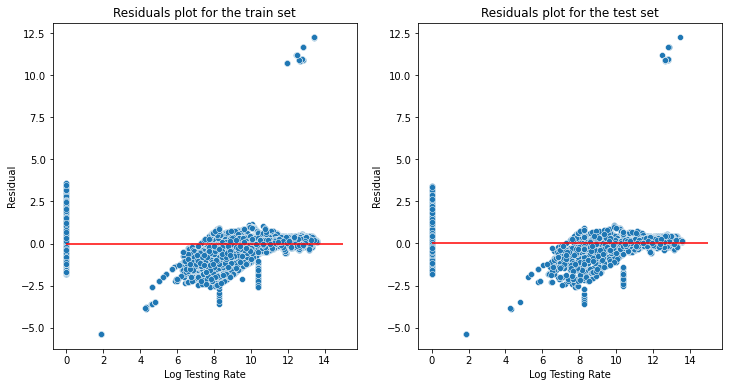

In [32]:
train_residuals = Y_train_tr - tr_model.predict(X_train_tr)
test_residuals = Y_test_tr - tr_model.predict(X_test_tr)
plt.figure(figsize=(12,6))
plt.subplot(121)
sns.scatterplot(x = Y_train_tr, y = train_residuals)
plt.title("Residuals plot for the train set")
plt.xlabel("Log Testing Rate")
plt.ylabel("Residual")
plt.hlines(0, 0, 15, "r")
plt.subplot(122)
sns.scatterplot(x = Y_test_tr, y = test_residuals)
plt.title("Residuals plot for the test set")
plt.xlabel("Log Testing Rate")
plt.ylabel("Residual")
plt.hlines(0, 0, 15, "r")